# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [955]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model

In [956]:
## Load the data into a DataFrame

#UnComment your own base dir. 

#JPF BASE DIR
base_dir = "/Users/jfreeley/GA-DSI/DSI_IMAGE/projects/projects-weekly/project-03/starter-code/data/"
#JO BASE DIR
#base_dir = 
#JB BASE DIR
#base_dir = 
df = pd.read_csv(base_dir + 'Iowa_Liquor_sales_sample_10pct.csv')
zcy = pd.read_csv(base_dir + 'ia_zip_city_county.csv')

In [957]:
#df3 = df2.merge(demo_df, left_on='Zip Code', right_on='Area')
df1 = df.merge(zcy, left_on='Zip Code', right_on='zip', how='left')
df1[df1['zip'].isnull()][['Store Number','Zip Code']].drop_duplicates()


,Store Number,Zip Code
78,5142,52303
114,4307,712-2
267,5054,52087
464,3805,52084
1871,4722,56201
4942,2954,50300
6664,2956,50300


In [958]:
# Store Zip Fixes
# store zip
# 5142, 52403
# 5054, 52057
# 3805, 52804
# 2954, 50312
# 2956, 50321
# 4722, 52601
# 4307, 51529

df.ix[df['Store Number']==5142, 'Zip Code'] = '52403'
df.ix[df['Store Number']==5054, 'Zip Code'] = '52057'
df.ix[df['Store Number']==3805, 'Zip Code'] = '52804'
df.ix[df['Store Number']==2954, 'Zip Code'] = '50312'
df.ix[df['Store Number']==2956, 'Zip Code'] = '50321'
df.ix[df['Store Number']==4722, 'Zip Code'] = '52601'
df.ix[df['Store Number']==4307, 'Zip Code'] = '51529'

In [959]:
## Transform the dates column
df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%Y')

In [960]:
df.head(3)

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34


Columns that we would be interested in:
- Date
- Store number
- City
- Zip code
- County
- Category
- Category name
- Vendor number
- Item number
- Item description
- State bottle cost
- State bottle retail
- Bottles sold
- Sales (dollars)
- Volumes (liters)

In [961]:
#Clean Cities by Hand
# Seems like there are duplicates in city where the upper and lower case doesnt match
df['City'] = df['City'].map(lambda x: x.title())

# Guttenberg has been misspelled in some entries
df['City'] = df['City'].map(lambda x: 'Guttenberg' if x == 'Guttenburg' else x)

# Let's use Arnolds Park without the apostrophe
df['City'] = df['City'].map(lambda x: 'Arnolds Park' if x == "Arnold'S Park" else x)

# Kellogg has been misspelled in some entries
df['City'] = df['City'].map(lambda x: 'Kellogg' if x == 'Kellog' else x)

# Let's use Mount instead of Mt
df['City'] = df['City'].map(lambda x: 'Mount Pleasant' if x == "Mt Pleasant" else x)
df['City'] = df['City'].map(lambda x: 'Mount Vernon' if x == "Mt Vernon" else x)

# Ottumwa has been misspelled in some entries
df['City'] = df['City'].map(lambda x: 'Ottumwa' if x == 'Ottuwma' else x)

# Remove city from Rockwell city
df['City'] = df['City'].map(lambda x: 'Rockwell' if x == 'Rockwell City' else x)


In [962]:
# Zip code should be integers

# Find the entries which are causing the type to be forced to object
# We may have to do this a few times, so we'll define a function that takes a column name to do it
def find_non_int(col):
    non_int = []
    for i in df[col]:
        try:
            int(i)
        except:
            if i not in non_int:
                non_int.append(i)
    non_int = pd.Series(non_int)
    return non_int.value_counts(dropna=False)
print find_non_int('Zip Code')

Series([], dtype: int64)


In [963]:
# Find the cities that have '712-2' as the zip code

df['City'][df['Zip Code'] == '712-2'].unique()

array([], dtype=object)

In [964]:
# Find the corresponding zip codes and counties for entries with 'Dunlap' as city
print df['Zip Code'][df['City'] == 'Dunlap'].unique()
print df['County'][df['City'] == 'Dunlap'].unique()
print df['County Number'][df['City'] == 'Dunlap'].unique()

['51529']
['Harrison' nan]
[ 43.  nan]


Based on [Wikipedia](https://en.wikipedia.org/wiki/Dunlap,_Iowa),

> Dunlap is a city in Harrison County, Iowa, United States, along the Boyer River.

> County: Harrison

> Zip code: 51529

In [965]:
# For all entries with 'DUNLAP' as city
# Set zip code as 51529
df.ix[df['City']=='Dunlap', 'Zip Code'] = '51529'

# Set county as Harrison
df.ix[df['City']=='Dunlap', 'County'] = 'Harrison'

# Set county number as 43.0
df.ix[df['City']=='Dunlap', 'County Number'] = 43.0

In [966]:
# Now change zip code to integers
df['Zip Code'] = df['Zip Code'].astype(int)

In [967]:
df.dtypes

Date                     datetime64[ns]
Store Number                      int64
City                             object
Zip Code                          int64
County Number                   float64
County                           object
Category                        float64
Category Name                    object
Vendor Number                     int64
Item Number                       int64
Item Description                 object
Bottle Volume (ml)                int64
State Bottle Cost                object
State Bottle Retail              object
Bottles Sold                      int64
Sale (Dollars)                   object
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
dtype: object

City, Zip code, County and County Number should be related

In [968]:
# Write a function that cross references City, Zip Code, County and County Number
# and fills the data in where it's missing
def fill_missing(related_cols, column):
    related_cols.remove(column)
    reference = df[related_cols][df[column].isnull()].drop_duplicates()
    for j in range(len(related_cols)):
        col_1 = reference[related_cols[j]]
        for i in col_1:
            try:
                value = df[column][(df[related_cols[j]]==i) & (df[column].notnull())].drop_duplicates().iloc[0]
                df.iloc[(df[related_cols[j]]==i) & (df[column].isnull()), column] = value
            except:
                pass

In [969]:
fill_missing(['Store Number', 'City', 'Zip Code', 'County', 'County Number'], 'County')

In [970]:
fill_missing(['Category', 'Category Name'], 'Category Name')
fill_missing(['Category', 'Category Name'], 'Category')

In [971]:
fill_missing(['Item Number', 'Item Description'], 'Item Description')
fill_missing(['Item Number', 'Item Description'], 'Item Number')

In [972]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 18 columns):
Date                     270955 non-null datetime64[ns]
Store Number             270955 non-null int64
City                     270955 non-null object
Zip Code                 270955 non-null int64
County Number            269909 non-null float64
County                   269909 non-null object
Category                 270887 non-null float64
Category Name            270323 non-null object
Vendor Number            270955 non-null int64
Item Number              270955 non-null int64
Item Description         270955 non-null object
Bottle Volume (ml)       270955 non-null int64
State Bottle Cost        270955 non-null object
State Bottle Retail      270955 non-null object
Bottles Sold             270955 non-null int64
Sale (Dollars)           270955 non-null object
Volume Sold (Liters)     270955 non-null float64
Volume Sold (Gallons)    270955 non-null float64
dtypes: datetime64[

In [973]:
# Convert all dollar columns to floats
df['State Bottle Cost'] = df['State Bottle Cost'].map(lambda x: x.strip('$')).astype(float)
df['State Bottle Retail'] = df['State Bottle Retail'].map(lambda x: x.strip('$')).astype(float)
df['Sale (Dollars)'] = df['Sale (Dollars)'].map(lambda x: x.strip('$')).astype(float)

In [974]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270955 entries, 0 to 270954
Data columns (total 18 columns):
Date                     270955 non-null datetime64[ns]
Store Number             270955 non-null int64
City                     270955 non-null object
Zip Code                 270955 non-null int64
County Number            269909 non-null float64
County                   269909 non-null object
Category                 270887 non-null float64
Category Name            270323 non-null object
Vendor Number            270955 non-null int64
Item Number              270955 non-null int64
Item Description         270955 non-null object
Bottle Volume (ml)       270955 non-null int64
State Bottle Cost        270955 non-null float64
State Bottle Retail      270955 non-null float64
Bottles Sold             270955 non-null int64
Sale (Dollars)           270955 non-null float64
Volume Sold (Liters)     270955 non-null float64
Volume Sold (Gallons)    270955 non-null float64
dtypes: datetime

In [975]:
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,Sumner,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,Davenport,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,Cedar Falls,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,12.59,18.89,24,453.36,24.0,6.34
3,2016-02-03,2501,Ames,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,9.50,14.25,6,85.50,10.5,2.77
4,2015-08-18,3654,Belmond,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,21.0,5.55



# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [976]:
cols = ['Date', 'Store Number', 'City', 'Zip Code', 'County', 'Category', 'Category Name', \
        'Vendor Number', 'Item Number', 'Item Description', 'Bottle Volume (ml)', 'State Bottle Cost', \
        'State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)']

In [977]:
df2 = df.copy()[cols]

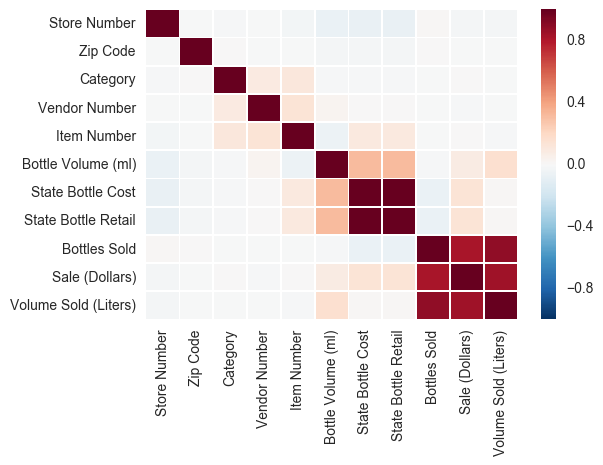

In [978]:
sns.heatmap(df2.corr(), linewidths=0.5)

In [979]:
df2.dropna(inplace=True)

r-squared: 0.842141679754


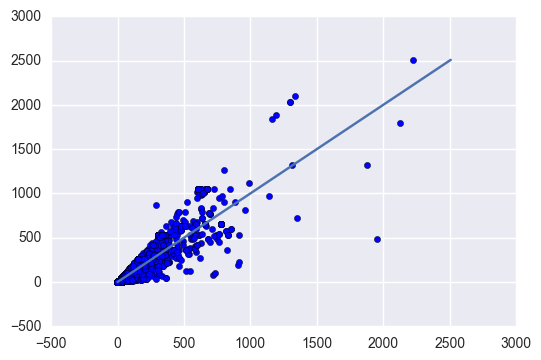

In [980]:
X = df2[['Zip Code','Bottle Volume (ml)', 'Bottles Sold', 'Sale (Dollars)']]
y = df2['Volume Sold (Liters)']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
print 'r-squared: {}'.format(model.score(X,y))
predicted = model.predict(X)
plt.scatter(predicted, y)
plt.plot([min(y), max(y)], [min(y), max(y)], '-')
plt.show()

In [981]:
demo_df = pd.read_csv(base_dir + 'IowaZIPdemos.csv')

In [982]:
demo_df.dropna(inplace=True)
demo_df['Area'] = demo_df['Area'].astype(int)

In [983]:
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 946 entries, 0 to 945
Data columns (total 42 columns):
Area                                946 non-null int64
Total Pop                           946 non-null object
Median HH Inc                       946 non-null object
Per Capita Inc                      946 non-null object
White                               946 non-null object
Afr Amer                            946 non-null object
Native Amer                         946 non-null int64
Asian Amer                          946 non-null object
Pac Islander                        946 non-null int64
Other                               946 non-null object
Bi- Multi-Racial                    946 non-null int64
Hispanic or Latino                  946 non-null object
Med Age                             946 non-null float64
<5 years                            946 non-null int64
5-17 yrs                            946 non-null int64
18-20 yrs                           946 non-null int64
21-24

In [984]:
demo_df['Pop Below Poverty Level'].dtype

dtype('O')

In [985]:
demo_cols = demo_df.columns.values.tolist()
object_cols = [i for i in demo_cols if demo_df[i].dtype == 'O']

In [986]:
def rem_symbols(x):
    for i in [',', '%', '$', '-']:
        x = x.replace(i, '')
    try:
        return float(x)
    except:
        print x
    
for i in object_cols:
    demo_df[i] = demo_df[i].map(rem_symbols)

In [987]:
demo_df.dtypes

Area                                  int64
Total Pop                           float64
Median HH Inc                       float64
Per Capita Inc                      float64
White                               float64
Afr Amer                            float64
Native Amer                           int64
Asian Amer                          float64
Pac Islander                          int64
Other                               float64
Bi- Multi-Racial                      int64
Hispanic or Latino                  float64
Med Age                             float64
<5 years                              int64
5-17 yrs                              int64
18-20 yrs                             int64
21-24 yrs                             int64
25-34 yrs                             int64
35-44 yrs                             int64
45-54 yrs                             int64
55-59 yrs                             int64
60-64 yrs                             int64
65-74 yrs                       

In [988]:
demo_df.head()

,Area,Total Pop,Median HH Inc,Per Capita Inc,White,Afr Amer,Native Amer,Asian Amer,Pac Islander,Other,...,Family households,Married-couple family households,Single mother households,Nonfamily households,Single Occupancy,Avg HH Size,Avg Family Size,Pop Below Poverty Level,% P25+ HS Grad,% P25-54 BA+
0,50001,615.0,43611.0,17803.0,594.0,3.0,1,0.0,0,2.0,...,174.0,158.0,12.0,42.0,34.0,2.85,3.21,711.0,88.8,9.7
1,50002,1339.0,32500.0,20580.0,1323.0,0.0,1,5.0,0,2.0,...,370.0,333.0,30.0,205.0,185.0,2.25,2.86,1232.0,87.6,11.2
2,50003,5835.0,47649.0,22429.0,5733.0,8.0,6,22.0,0,23.0,...,1615.0,1390.0,162.0,619.0,529.0,2.58,3.08,5816.0,91.0,24.0
3,50005,851.0,41786.0,15267.0,840.0,0.0,5,4.0,0,0.0,...,251.0,208.0,28.0,69.0,56.0,2.66,2.98,917.0,80.8,12.7
4,50006,1959.0,36494.0,16957.0,1930.0,0.0,1,3.0,0,21.0,...,547.0,477.0,43.0,220.0,194.0,2.55,3.09,1939.0,88.9,14.8


In [989]:
df3 = df2.merge(demo_df, left_on='Zip Code', right_on='Area')

In [990]:
df3['Month'] = df3['Date'].map(lambda x: x.month)
df3['Year'] = df3['Date'].map(lambda x: x.year)

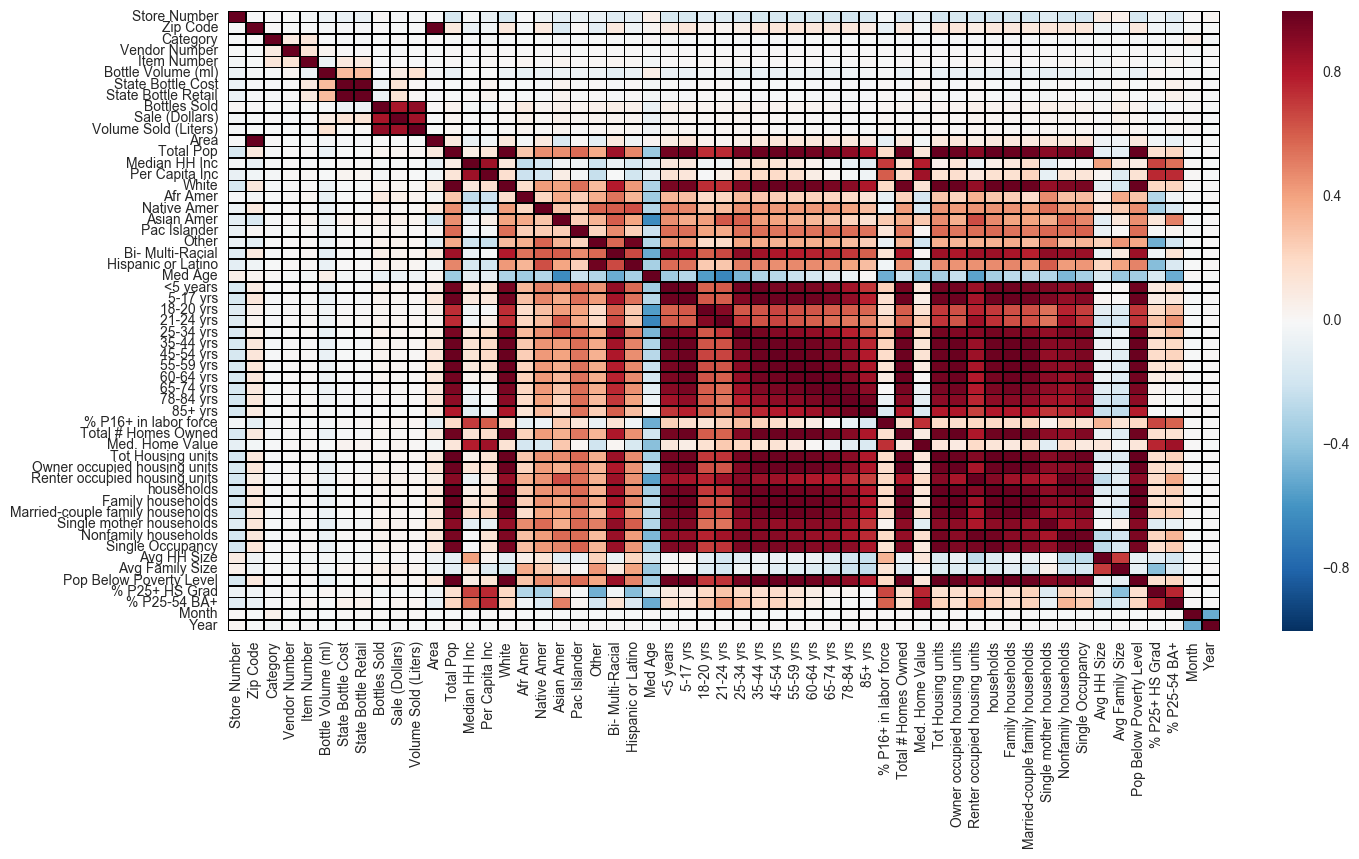

In [991]:
fig = plt.subplots(figsize=(16,8))
sns.heatmap(df3.corr(), linewidths=0.5, linecolor='#000000')

In [992]:
df4 = pd.pivot_table(df3, index=['Zip Code','Year'], \
      values=['Bottles Sold', 'Volume Sold (Liters)', 'Sale (Dollars)'], aggfunc=sum).reset_index()
df4

,Zip Code,Year,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
0,50002,2015,498,4958.04,335.85
1,50002,2016,90,893.16,55.50
2,50003,2015,2918,38095.16,2737.52
3,50003,2016,719,9620.94,784.48
4,50006,2015,640,10086.97,719.24
5,50006,2016,116,2193.27,141.00
6,50009,2015,17953,241028.59,16284.00
7,50009,2016,4712,53529.80,3998.54
8,50010,2015,53617,772044.25,52520.63
9,50010,2016,11121,159057.33,10792.80


In [993]:
df4.to_csv('../data/liqour_plus_demo.csv')

In [994]:
# groupby store, then by year
df3_gb = df3[['Zip Code','Store Number']].drop_duplicates()
df3_gb = df3_gb.rename(columns={'Store Number': 'StoreCount'})
df3_gb = df3_gb.groupby(['Zip Code']).count().reset_index()
df4 = df4.merge(df3_gb, left_on='Zip Code', right_on='Zip Code')

In [995]:
df5 = df4.merge(demo_df, left_on='Zip Code', right_on='Area')

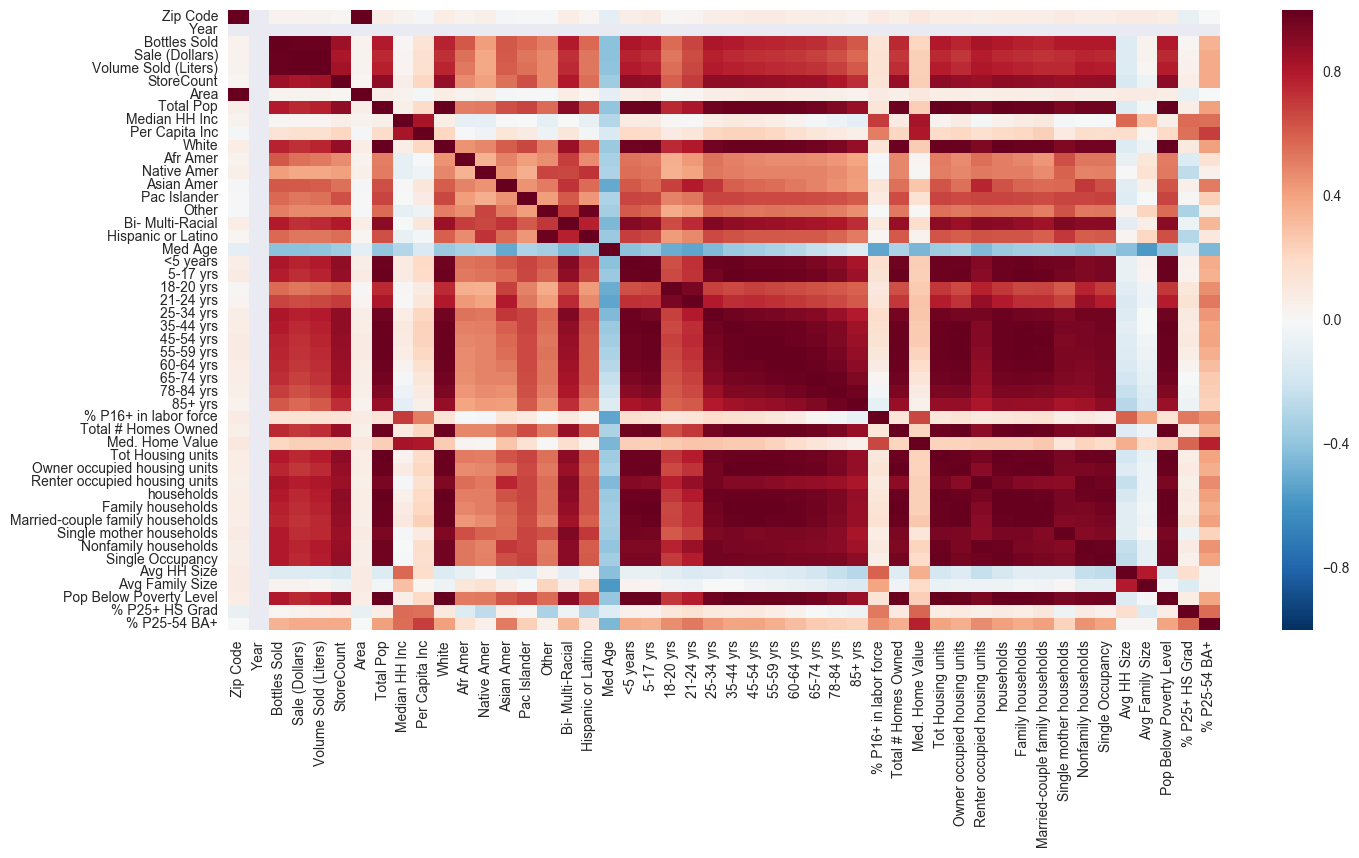

In [996]:
fig = plt.subplots(figsize=(16,8))
sns.heatmap(df5[df5['Year']==2015].corr())

In [997]:
df5.shape

(793, 48)

In [998]:
#df5['Above 21'] = pd.Series(df5[df5.columns.values[22:31]].sum(axis=1))

In [999]:
df5.head()

,Zip Code,Year,Bottles Sold,Sale (Dollars),Volume Sold (Liters),StoreCount,Area,Total Pop,Median HH Inc,Per Capita Inc,...,Family households,Married-couple family households,Single mother households,Nonfamily households,Single Occupancy,Avg HH Size,Avg Family Size,Pop Below Poverty Level,% P25+ HS Grad,% P25-54 BA+
0,50002,2015,498,4958.04,335.85,2,50002,1339.0,32500.0,20580.0,...,370.0,333.0,30.0,205.0,185.0,2.25,2.86,1232.0,87.6,11.2
1,50002,2016,90,893.16,55.50,2,50002,1339.0,32500.0,20580.0,...,370.0,333.0,30.0,205.0,185.0,2.25,2.86,1232.0,87.6,11.2
2,50003,2015,2918,38095.16,2737.52,3,50003,5835.0,47649.0,22429.0,...,1615.0,1390.0,162.0,619.0,529.0,2.58,3.08,5816.0,91.0,24.0
3,50003,2016,719,9620.94,784.48,3,50003,5835.0,47649.0,22429.0,...,1615.0,1390.0,162.0,619.0,529.0,2.58,3.08,5816.0,91.0,24.0
4,50006,2015,640,10086.97,719.24,2,50006,1959.0,36494.0,16957.0,...,547.0,477.0,43.0,220.0,194.0,2.55,3.09,1939.0,88.9,14.8


In [1000]:
df3.corr().loc['Sale (Dollars)',:]

Store Number                       -0.017730
Zip Code                           -0.004838
Category                            0.006460
Vendor Number                      -0.012434
Item Number                         0.002222
Bottle Volume (ml)                  0.082285
State Bottle Cost                   0.136244
State Bottle Retail                 0.136427
Bottles Sold                        0.825888
Sale (Dollars)                      1.000000
Volume Sold (Liters)                0.846418
Area                               -0.004838
Total Pop                           0.025874
Median HH Inc                      -0.005779
Per Capita Inc                      0.004301
White                               0.018736
Afr Amer                            0.056791
Native Amer                         0.021130
Asian Amer                          0.047590
Pac Islander                        0.015819
Other                               0.039770
Bi- Multi-Racial                    0.042488
Hispanic o

In [1001]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 793 entries, 0 to 792
Data columns (total 48 columns):
Zip Code                            793 non-null int64
Year                                793 non-null int64
Bottles Sold                        793 non-null int64
Sale (Dollars)                      793 non-null float64
Volume Sold (Liters)                793 non-null float64
StoreCount                          793 non-null int64
Area                                793 non-null int64
Total Pop                           793 non-null float64
Median HH Inc                       793 non-null float64
Per Capita Inc                      793 non-null float64
White                               793 non-null float64
Afr Amer                            793 non-null float64
Native Amer                         793 non-null int64
Asian Amer                          793 non-null float64
Pac Islander                        793 non-null int64
Other                               793 non-null float

In [1002]:
df6 = df5.copy()

In [1003]:
sales_median = df5['Sale (Dollars)'].median()
sales_std = df5['Sale (Dollars)'].std()

In [1004]:
df5 = df5[abs(df5['Sale (Dollars)'] - sales_median) <= 3*sales_std]
df5 = df5[df5['Year']==2015]

In [1005]:
df5['Sale (Dollars)'].describe()

count       375.000000
mean      39316.867840
std       61242.127473
min          90.000000
25%        3807.780000
50%       10245.140000
75%       46452.415000
max      320296.590000
Name: Sale (Dollars), dtype: float64

In [1006]:
features = df5.columns.values.tolist()
print features

drop_features = ['Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)', 'Zip Code']
for i in drop_features:
    features.remove(i)

['Zip Code', 'Year', 'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)', 'StoreCount', 'Area', 'Total Pop', 'Median HH Inc', 'Per Capita Inc', 'White', 'Afr Amer', 'Native Amer', 'Asian Amer', 'Pac Islander', 'Other', 'Bi- Multi-Racial', 'Hispanic or Latino', 'Med Age', '<5 years', '5-17 yrs', '18-20 yrs', '21-24 yrs', '25-34 yrs', '35-44 yrs', '45-54 yrs', '55-59 yrs', '60-64 yrs', '65-74 yrs', '78-84 yrs', '85+ yrs', '% P16+ in labor force', 'Total # Homes Owned', 'Med. Home Value', 'Tot Housing units', 'Owner occupied housing units', 'Renter occupied housing units', 'households', 'Family households', 'Married-couple family households', 'Single mother households', 'Nonfamily households', 'Single Occupancy', 'Avg HH Size', 'Avg Family Size', 'Pop Below Poverty Level', '% P25+ HS Grad', '% P25-54 BA+']


In [1007]:
features

['Year',
 'StoreCount',
 'Area',
 'Total Pop',
 'Median HH Inc',
 'Per Capita Inc',
 'White',
 'Afr Amer',
 'Native Amer',
 'Asian Amer',
 'Pac Islander',
 'Other',
 'Bi- Multi-Racial',
 'Hispanic or Latino',
 'Med Age',
 '<5 years',
 '5-17 yrs',
 '18-20 yrs',
 '21-24 yrs',
 '25-34 yrs',
 '35-44 yrs',
 '45-54 yrs',
 '55-59 yrs',
 '60-64 yrs',
 '65-74 yrs',
 '78-84 yrs',
 '85+ yrs',
 '% P16+ in labor force',
 'Total # Homes Owned',
 'Med. Home Value',
 'Tot Housing units',
 'Owner occupied housing units',
 'Renter occupied housing units',
 'households',
 'Family households',
 'Married-couple family households',
 'Single mother households',
 'Nonfamily households',
 'Single Occupancy',
 'Avg HH Size',
 'Avg Family Size',
 'Pop Below Poverty Level',
 '% P25+ HS Grad',
 '% P25-54 BA+']

In [1008]:
X = df5[features]
y = df5['Sale (Dollars)']
ridge = linear_model.RidgeCV(cv=5)
model = ridge.fit(X,y)
model.score(X,y)

0.86108188630141624

In [1009]:
model.alpha_

10.0

In [1010]:
from sklearn.metrics import r2_score

In [1011]:
r2_score(y, model.predict(X))

0.86108188630141624

In [1012]:
feature_imp = pd.DataFrame([features, model.coef_.tolist()], index=['feature', 'coef']).T

In [1013]:
x = feature_imp.sort_values(by='coef', ascending=False)

In [1014]:
x['coef'] = x['coef'].astype(float)

In [1015]:
print x[((x['coef'] < 2) & (x['coef'] >-2))]['feature'].tolist()

['Per Capita Inc', 'Year', 'Med. Home Value', 'Median HH Inc']


In [1016]:
x

,feature,coef
1,StoreCount,8390.607619
40,Avg Family Size,2381.831610
43,% P25-54 BA+,956.273593
10,Pac Islander,854.283502
36,Single mother households,371.986034
35,Married-couple family households,260.228184
38,Single Occupancy,155.543092
3,Total Pop,127.470213
22,55-59 yrs,78.352928
16,5-17 yrs,66.355523


In [1017]:
predicted = model.predict(X)

In [1018]:
df_pred = pd.DataFrame(predicted)
df_pred.reset_index(drop=True, inplace=True)
df5.reset_index(drop=True, inplace=True)

df_pred.info()
final = pd.concat([df5,df_pred], axis = 1)
final.to_csv('ia_zip_predictions.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 1 columns):
0    375 non-null float64
dtypes: float64(1)
memory usage: 3.0 KB


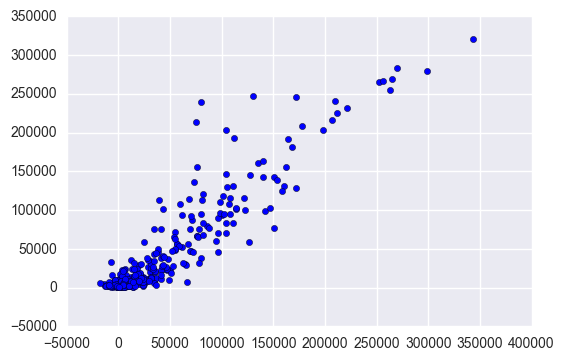

In [1019]:
plt.scatter(predicted, y)

In [1020]:
X_pred = demo_df[features]

predicted = model.predict(X_pred)

df_pred = pd.DataFrame(predicted)
df_pred.reset_index(drop=True, inplace=True)
df5.reset_index(drop=True, inplace=True)

df_pred.info()
final = pd.concat([demo_df,df_pred], axis = 1)
#df1 = df.merge(zcy, left_on='Zip Code', right_on='zip', how='left')
final = final.merge(df4,left_on="Area", right_on="Zip Code", how='left')
final.to_csv('ia_zip_predictions_all_zips.csv')
final

KeyError: "['Year' 'StoreCount'] not in index"

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [ ]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.